In [1]:
!pip3 install -r requirements.txt
import os
import re
import glob
import string
import datetime
from cluster import Cluster
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import email
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stem = WordNetLemmatizer()
nltk.download('stopwords')
stopwords_list = stopwords.words('english')


You should consider upgrading via the '/Users/johnsica/projects/alaffia/env/bin/python -m pip install --upgrade pip' command.


Matplotlib created a temporary config/cache directory at /var/folders/2r/d_g805s148zd3dd01yqq5qtr0000gn/T/matplotlib-r_5jnrnj because the default path (/Users/johnsica/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnsica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnsica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Clean email documents and store in dataframe

In [2]:
def parse_folder(folder):
    df = pd.DataFrame(columns=columns)
    for index,file in enumerate(folder):
        if 'genie' in file:
            continue
        df.loc[index,'category'] = file.split('skilling-j/')[1].split('/')[0]
        try:
            with open(file,'r') as f:
                content = email.message_from_file(f)
        except:
            with open(file,'r',encoding="latin-1") as f:
                content = email.message_from_file(f)

        df.loc[index,'ID'] = content.get('Message-ID')
        df.loc[index,'Date'] = datetime.datetime.strptime(content.get('Date').split('(')[0].strip(),'%a, %d %b %Y %H:%M:%S %z')
        df.loc[index,'From'] = content.get('From')
        df.loc[index,'To'] = content.get('To')
        subject = content.get('Subject').lower()
        subject = re.sub(r"[@='_,;.!\?\-:#$%&\b\d+\b]",'', subject)
        subject = [word for word in subject.split() if word not in stopwords_list]
        df.at[index,'Subject'] = ' '.join([stem.lemmatize(word) for word in subject])
        df.loc[index,'Mime-Version'] = content.get('Mime-Version')
        df.loc[index,'Content-Type'] = content.get('Content-Type')
        df.loc[index,'Content-Transer-Encoding'] = content.get('Content-Transer-Encoding')
        df.loc[index,'X-From'] = content.get('X-From')
        df.loc[index,'X-To'] = content.get('X-To')
        df.loc[index,'X-cc'] = content.get('X-cc')
        df.loc[index,'X-bcc'] = content.get('X-bcc')
        df.loc[index,'X-Folder'] = content.get('X-Folder')
        df.loc[index,'X-Origin'] = content.get('X-Origin')
        df.loc[index,'X-FileName'] = content.get('X-FileName')
        content = content.get_payload().lower()
        content = content.replace('\n',' ')
        content = content.replace('yahoo',' ')
        content = re.sub(r"[@='_,;.!\?\-:#$%&\b\d+\b]",'', content)
        sent = [word for word in content.split() if word not in stopwords_list]
        body = ' '.join([stem.lemmatize(word) for word in sent])
        df.at[index,'body'] = body
        f.close()
    return df
    
    

In [3]:
columns = [
    'ID',
    'Date',
    'From',
    'To',
    'Subject',
    'Mime-Version',
    'Content-Type',
    'Content-Transfer-Encoding',
    'X-From',
    'X-To',
    'X-cc',
    'X-bcc',
    'X-Folder',
    'X-Origin',
    'X-FileName',
    'body'
]


In [4]:
# initialize dataframes
skilling_folder = glob.glob(os.getcwd()+'/data/skilling-j/*')
notes_inbox = parse_folder(glob.glob(skilling_folder[0]+'/*'))
deleted_items = parse_folder(glob.glob(skilling_folder[1]+'/*'))
calendar = parse_folder(glob.glob(skilling_folder[2]+'/*'))
inbox = parse_folder(glob.glob(skilling_folder[3]+'/*'))
discussion_threads = parse_folder(glob.glob(skilling_folder[4]+'/*'))
contacts = parse_folder(glob.glob(skilling_folder[5]+'/*'))
sent_items = parse_folder(glob.glob(skilling_folder[6]+'/*'))
mark = parse_folder(glob.glob(skilling_folder[7]+'/*'))
sent = parse_folder(glob.glob(skilling_folder[8]+'/*'))
_sent_mail = parse_folder(glob.glob(skilling_folder[9]+'/*'))
all_documents = parse_folder(glob.glob(skilling_folder[10]+'/*'))

df_all_docs = pd.concat([
    notes_inbox,
    deleted_items,
    calendar,
    inbox,
    discussion_threads,
    contacts,
    sent_items,
    mark,
    sent,
    _sent_mail,
    all_documents
],ignore_index=True)


### Flagged words

In [5]:
bankruptcy_idx,litigation_idx,fraud_idx = [],[],[]
for index,row in df_all_docs.iterrows():
    if 'fraud' in row['body'] or 'fraud' in row['Subject']:
        fraud_idx.append(index)
    if 'bankrupt' in row['body'] or 'bankrupt' in row['Subject']:
        bankruptcy_idx.append(index)
    for word in ['litigate','litigation']:
        if word in row['body'] or word in row['Subject'] and index not in litigation_idx:
            litigation_idx.append(index)
            
df_fraud = df_all_docs[df_all_docs.index.isin(fraud_idx)]
df_bankrupt = df_all_docs[df_all_docs.index.isin(bankruptcy_idx)]
df_litigation = df_all_docs[df_all_docs.index.isin(litigation_idx)]


### Litigation keyword model

In [6]:
lit_model = Cluster(df_litigation,4)

array([-1,  0,  0,  0,  0,  0, -1, -1, -1, -1])

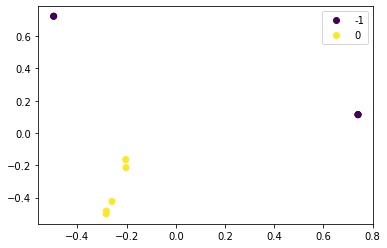

In [7]:
lit_model.dbscan(0.4)

In [8]:
lit_features = lit_model.get_top_features(30)

<AxesSubplot:xlabel='score', ylabel='features'>

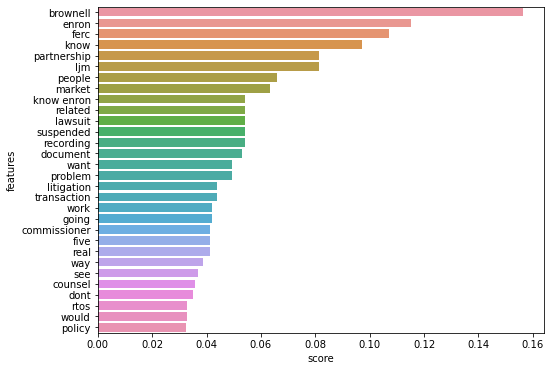

In [9]:
# features[2] offers interesting top features (brownell,ferc,lawsuit,litigation,problem)
# features[0] has many features related to markets/trading
plt.figure(figsize=(8,6))
sns.barplot(x='score',y='features',orient='h', data = lit_features[2][:30])

In [10]:
lit_common = lit_model.get_common_words()


### Fraud keyword model

In [11]:
fraud_model = Cluster(df_fraud,4)

array([ 0,  0,  0,  0,  0, -1, -1, -1, -1])

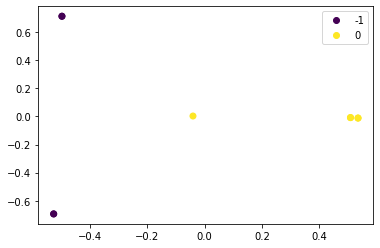

In [12]:
fraud_model.dbscan(0.6)

In [13]:
fraud_features = fraud_model.get_top_features(30)

<AxesSubplot:xlabel='score', ylabel='features'>

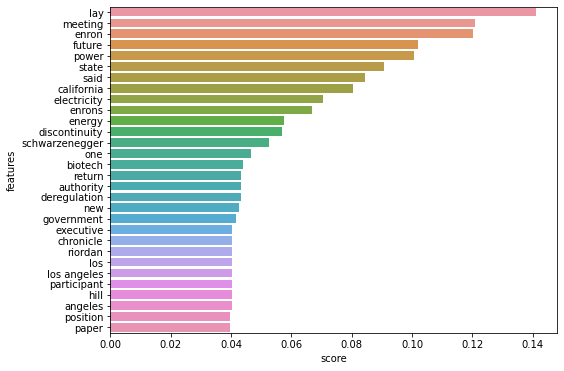

In [14]:
plt.figure(figsize=(8,6))
sns.barplot(x='score',y='features',orient='h', data = fraud_features[3][:30])

#### Bankruptcy keyword model

In [15]:
bankruptcy_model = Cluster(df_bankrupt,4)

In [16]:
bankruptcy_features = bankruptcy_model.get_top_features(30)

<AxesSubplot:xlabel='score', ylabel='features'>

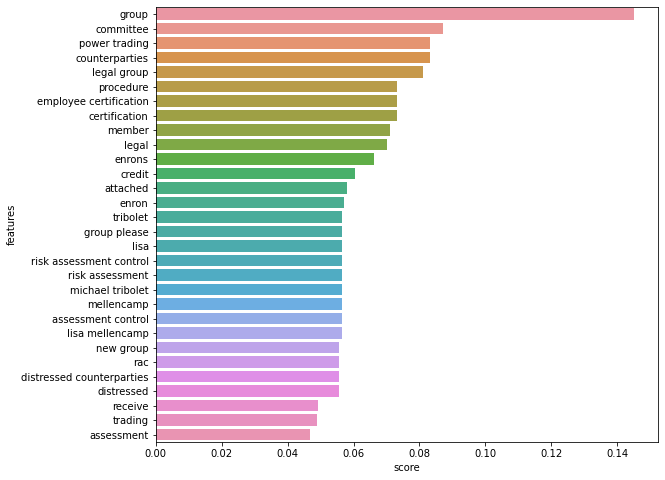

In [17]:
plt.figure(figsize=(9,8))
sns.barplot(x='score',y='features',orient='h', data = bankruptcy_features[0][:30])

### Key Time Frame

In [18]:
# looking through documents leading up to skilling's resignation - august 14, 2001
key_idx = []
for idx,row in df_all_docs.iterrows():
    dt = datetime.date(row['Date'].year,row['Date'].month,row['Date'].day)
    if dt > datetime.date(2001,6,29) and dt < datetime.date(2001,8,15):
        key_idx.append(idx)

df_key_timeframe = df_all_docs[df_all_docs.index.isin(key_idx)]
key_timeframe_model = Cluster(df_key_timeframe,3)


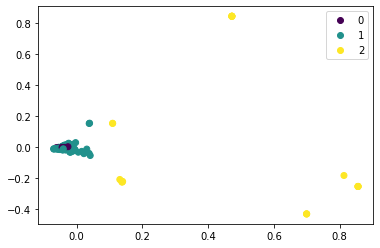

In [19]:
key_timeframe_model.plot_data(key_timeframe_model.labels)

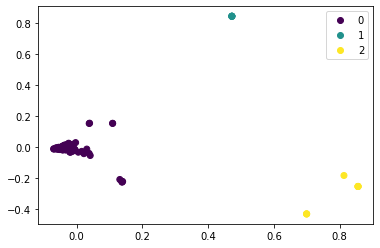

In [20]:
clusters = key_timeframe_model.dbscan(0.3)

In [21]:
timeframe_features = key_timeframe_model.get_top_features(30)

<AxesSubplot:xlabel='score', ylabel='features'>

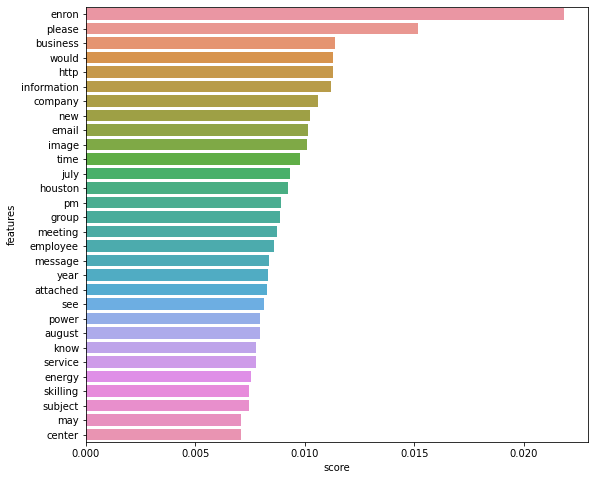

In [43]:
plt.figure(figsize=(9,8))
sns.barplot(x='score',y='features',orient='h', data = timeframe_features[1][:30])

In [44]:
common_words = key_timeframe_model.get_common_words()
for word in common_words.most_common(100):
    print(word)

('skilling', 948)
('please', 948)
('dear', 632)
('ljm', 632)
('plan', 632)
('attend', 632)
('new', 632)
('business', 632)
('creation', 632)
('original', 632)
('message', 632)
('wednesday', 632)
('246', 316)
('minute', 316)
('could', 316)
('get', 316)
('enron', 316)
('federal', 316)
('credit', 316)
('union', 316)
('su', 316)
('247', 316)
('guy', 316)
('currently', 316)
('vacation', 316)
('unable', 316)
('deliver', 316)
('person', 316)
('h', 316)
('249', 316)
('messrs', 316)
('lay', 316)
('writing', 316)
('hope', 316)
('assist', 316)
('c', 316)
('250', 316)
('mr', 316)
('mphasis', 316)
('global', 316)
('multicul', 316)
('252', 316)
('note', 316)
('coinvestment', 316)
('lp', 316)
('longer', 316)
('2648', 316)
('fernando', 316)
('receive', 316)
('email', 316)
('wanted', 316)
('assure', 316)
('concern', 316)
('2658', 316)
('wed', 316)
('2662', 316)
('jeff', 316)
('sent', 316)
('2666', 316)
('actual', 316)
('date', 316)
('august', 316)
('2675', 316)
('tue', 316)
('Name', 316)
('body', 316)
(

### Most messaged contacts

In [23]:
frequency = {}
for index,row in df_all_docs.iterrows():
    if row['To'] and ',' in row['To']:
        to = row['To'].split(',')
        for t in to:
            if t.strip() == 'jeff.skilling@enron.com':
                continue
            if t.strip() in frequency:
                frequency.update({t.strip():frequency.get(t.strip())+1})
            else:
                frequency.update({t.strip():1})
    elif row['To']:
        if row['To'].strip() != 'jeff.skilling@enron.com':
            if row['To'].strip() in frequency:
                frequency.update({row['To'].strip():frequency.get(row['To'].strip())+1})
            else:
                frequency.update({row['To'].strip():1})
    if ',' in row['From']:
        fro = row['From'].split(',')
        for f in fro:
            if f.strip() == 'jeff.skilling@enron.com':
                continue
            if f.strip() in frequency:
                frequency.update({f.strip():frequency.get(f.strip())+1})
            else:
                frequency.update({f.strip():1})
    else:
        if row['From'].strip() != 'jeff.skilling@enron.com':
            if row['From'].strip() in frequency:
                frequency.update({row['From'].strip():frequency.get(row['From'].strip())+1})
            else:
                frequency.update({row['From'].strip():1})
contact_freqs = {k: v for k, v in sorted(frequency.items(), key=lambda item: item[1],reverse=True)}
poi_list = [p for p in contact_freqs.keys() if contact_freqs.get(p) >= 100]
df_poi = df_all_docs[(df_all_docs['To'].isin(poi_list)) | (df_all_docs['From'].isin(poi_list))]


In [24]:
contact_freqs

{'sherri.sera@enron.com': 755,
 'kenneth.lay@enron.com': 287,
 'jskilli@enron.com': 234,
 'markskilling@hotmail.com': 215,
 'joannie.williamson@enron.com': 210,
 'greg.whalley@enron.com': 204,
 'mark.frevert@enron.com': 190,
 'steven.kean@enron.com': 190,
 'louise.kitchen@enron.com': 190,
 'john.sherriff@enron.com': 178,
 'smu-betas@yahoogroups.com': 167,
 'mike.mcconnell@enron.com': 165,
 'fredinvt@juno.com': 155,
 'sally.beck@enron.com': 147,
 'jeffrey.mcmahon@enron.com': 145,
 'boethia@hotmail.com': 145,
 'chuck.paul@a-closer-look.com': 144,
 'mark.koenig@enron.com': 141,
 '40enron@enron.com': 141,
 'kimberly.hillis@enron.com': 139,
 'jim.fallon@enron.com': 138,
 'tomskilljr@aol.com': 137,
 'rick.buy@enron.com': 126,
 'handshohl@eudoramail.com': 120,
 'rharman@bass-associates.com': 119,
 'craigd9561@aol.com': 119,
 'jawallace12050@aol.com': 115,
 'jansson@mindspring.com': 115,
 'bensons3@airmail.net': 114,
 'jimfulrich@aol.com': 114,
 'judgegyro@yahoo.com': 114,
 'azaremba@fzci.net'

In [25]:
sherri_idx = []
ken_idx = []
for index,row in df_poi.iterrows():
    if row['To']:
        if 'sherri.sera@enron.com' in row['To']:
            sherri_idx.append(index)
        if 'kenneth.lay@enron.com' in row['To']:
            ken_idx.append(index)
    if 'sherri.sera@enron.com' in row['From']:
        sherri_idx.append(index)
    if 'kenneth.lay@enron.com' in row['From']:
        ken_idx.append(index)
        

In [26]:
df_sherri = df_poi[df_poi.index.isin(sherri_idx)]
df_ken = df_poi[df_poi.index.isin(ken_idx)]

In [27]:
sherri_model = Cluster(df_sherri,4)

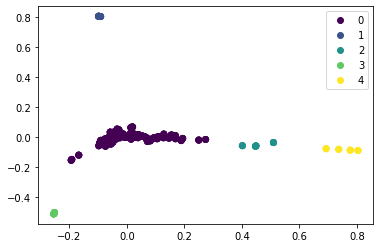

In [28]:
c = sherri_model.dbscan(0.1)

In [29]:
sherri_features = sherri_model.get_top_features(30)

<AxesSubplot:xlabel='score', ylabel='features'>

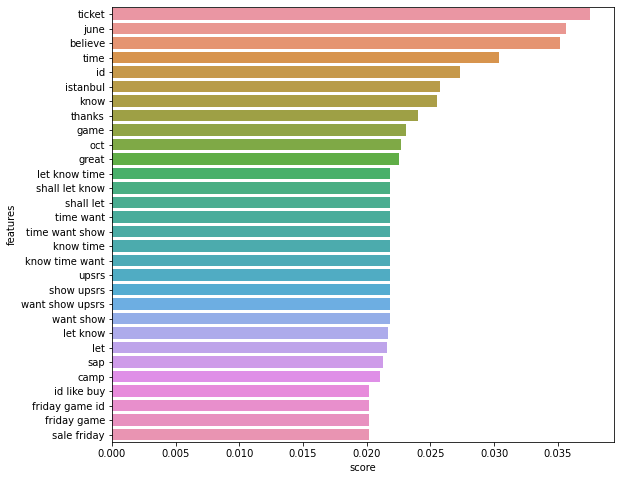

In [53]:
plt.figure(figsize=(9,8))
sns.barplot(x='score',y='features',orient='h', data = sherri_features[0][:30])

In [31]:
ken_model = Cluster(df_ken,3)

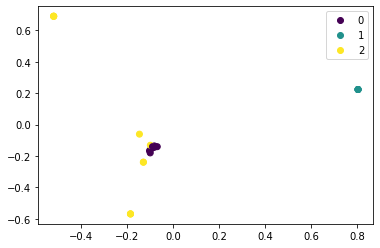

In [32]:
ken_model.plot_data(ken_model.labels)

In [33]:
ken_features = ken_model.get_top_features(30)

<AxesSubplot:xlabel='score', ylabel='features'>

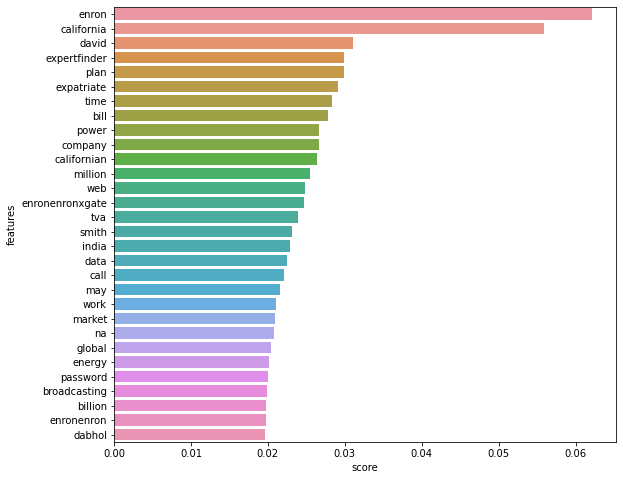

In [46]:
plt.figure(figsize=(9,8))
sns.barplot(x='score',y='features',orient='h', data = ken_features[0][:30])

### Output dataframes

In [35]:
df_fraud.to_csv(os.getcwd()+'fraud_docs.csv')
df_litigation.to_csv(os.getcwd()+'litigation_docs.csv')
df_bankrupt.to_csv(os.getcwd()+'bankrupt_docs.csv')
df_key_timeframe.to_csv(os.getcwd()+'key_timeframe_docs.csv')
df_sherri.to_csv(os.getcwd()+'sherri_docs.csv')
df_ken.to_csv(os.getcwd()+'ken_docs.csv')

### Deleted items

In [36]:
deleted_items_model = Cluster(df_all_docs[df_all_docs['category'] == 'deleted_items'],4)

In [ ]:
deleted_items_model.plot_data(deleted_items_model.labels)

In [ ]:
deleted_features = deleted_items_model.get_top_features(30)

In [ ]:
plt.figure(figsize=(9,8))
sns.barplot(x='score',y='features',orient='h', data = deleted_features[0][:30])

### Inbox


In [ ]:
inbox_model = Cluster(df_all_docs[df_all_docs['category'] == 'inbox'],4)

In [ ]:
inbox_model.plot_data(inbox_model.labels)

In [ ]:
inbox_model_features = inbox_model.get_top_features(30)

In [ ]:
plt.figure(figsize=(9,8))
sns.barplot(x='score',y='features',orient='h', data = inbox_model_features[0][:30])

### Sent mail

In [ ]:
sent_model = Cluster(df_all_docs[df_all_docs['category'] == 'sent'],4)

In [ ]:
sent_model.plot_data(sent_model.labels)

In [ ]:
sent_model_features = sent_model.get_top_features(30)

In [ ]:
plt.figure(figsize=(9,8))
sns.barplot(x='score',y='features',orient='h', data = sent_model_features[3][:30])